In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

In [20]:
#@markdown Plotting style (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
%matplotlib inline
 
#@markdown Resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

In [2]:
tf.__version__

'2.4.0'

## Kaggle dataset download

In [ ]:
# Upload kaggle.json file (API)
# https://www.kaggle.com/docs/api
files.upload()

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 320M/330M [00:06<00:00, 53.0MB/s]
100% 330M/330M [00:06<00:00, 55.6MB/s]


In [6]:
!unzip 'face-mask-12k-images-dataset.zip' -d face_mask_image_dataset
clear_output()

In [7]:
!rm face-mask-12k-images-dataset.zip
!mv "face_mask_image_dataset/Face Mask Dataset/Train/WithMask" "face_mask_image_dataset/Face Mask Dataset/Train/mask"
!mv "face_mask_image_dataset/Face Mask Dataset/Train/WithoutMask" "face_mask_image_dataset/Face Mask Dataset/Train/no_mask"
!mv "face_mask_image_dataset/Face Mask Dataset/Test/WithMask" "face_mask_image_dataset/Face Mask Dataset/Test/mask"
!mv "face_mask_image_dataset/Face Mask Dataset/Test/WithoutMask" "face_mask_image_dataset/Face Mask Dataset/Test/no_mask"
!mv "face_mask_image_dataset/Face Mask Dataset/Validation/WithMask" "face_mask_image_dataset/Face Mask Dataset/Validation/mask"
!mv "face_mask_image_dataset/Face Mask Dataset/Validation/WithoutMask" "face_mask_image_dataset/Face Mask Dataset/Validation/no_mask"

## Data preprocessing

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

train_generator = datagen.flow_from_directory(
    "face_mask_image_dataset/Face Mask Dataset/Train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

val_generator = datagen.flow_from_directory(
    "face_mask_image_dataset/Face Mask Dataset/Validation",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [9]:
val_generator.class_indices

{'mask': 0, 'no_mask': 1}

In [10]:
# .tflite labels
print(train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

{'mask': 0, 'no_mask': 1}


## MobileNetV2 + Binary Classifier

In [11]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
mnet_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


Freezing convolutional layers (feature extractor). Add top-level classifier.

In [12]:
for layer in mnet_model.layers:
  layer.trainable = False

In [13]:
models = mnet_model.output
models = AveragePooling2D(pool_size=(7, 7))(models)
models = Flatten(name="flatten")(models)
models = Dense(512, activation="relu")(models)
models = Dropout(0.5)(models)
models = Dense(128, activation="relu")(models)
models = Dropout(0.5)(models)
models = Dense(2, activation="softmax")(models) # output layer (2 neurons/classes)
# adding fully connected layers on top of the mnet_model ==> FINAL MODEL
model = Model(inputs=mnet_model.input, outputs=models)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# model.summary()

## Train model

In [15]:
checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')
print(f'Number of trainable variables: {len(model.trainable_variables)}')

Number of trainable variables: 6


In [16]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=10, # 8
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),
                    callbacks=[checkpoint])

Epoch 1/10
157/157 [==============================] - 456s 3s/step - loss: 0.2147 - accuracy: 0.9117 - val_loss: 0.0333 - val_accuracy: 0.9875
Epoch 2/10
157/157 [==============================] - 468s 3s/step - loss: 0.0681 - accuracy: 0.9792 - val_loss: 0.0199 - val_accuracy: 0.9937
Epoch 3/10
157/157 [==============================] - 480s 3s/step - loss: 0.0484 - accuracy: 0.9855 - val_loss: 0.0268 - val_accuracy: 0.9900
Epoch 4/10
157/157 [==============================] - 471s 3s/step - loss: 0.0474 - accuracy: 0.9853 - val_loss: 0.0308 - val_accuracy: 0.9862
Epoch 5/10
157/157 [==============================] - 467s 3s/step - loss: 0.0434 - accuracy: 0.9853 - val_loss: 0.0188 - val_accuracy: 0.9925
Epoch 6/10
157/157 [==============================] - 453s 3s/step - loss: 0.0309 - accuracy: 0.9902 - val_loss: 0.0595 - val_accuracy: 0.9762
Epoch 7/10
157/157 [==============================] - 444s 3s/step - loss: 0.0442 - accuracy: 0.9827 - val_loss: 0.0194 - val_accuracy: 0.9962

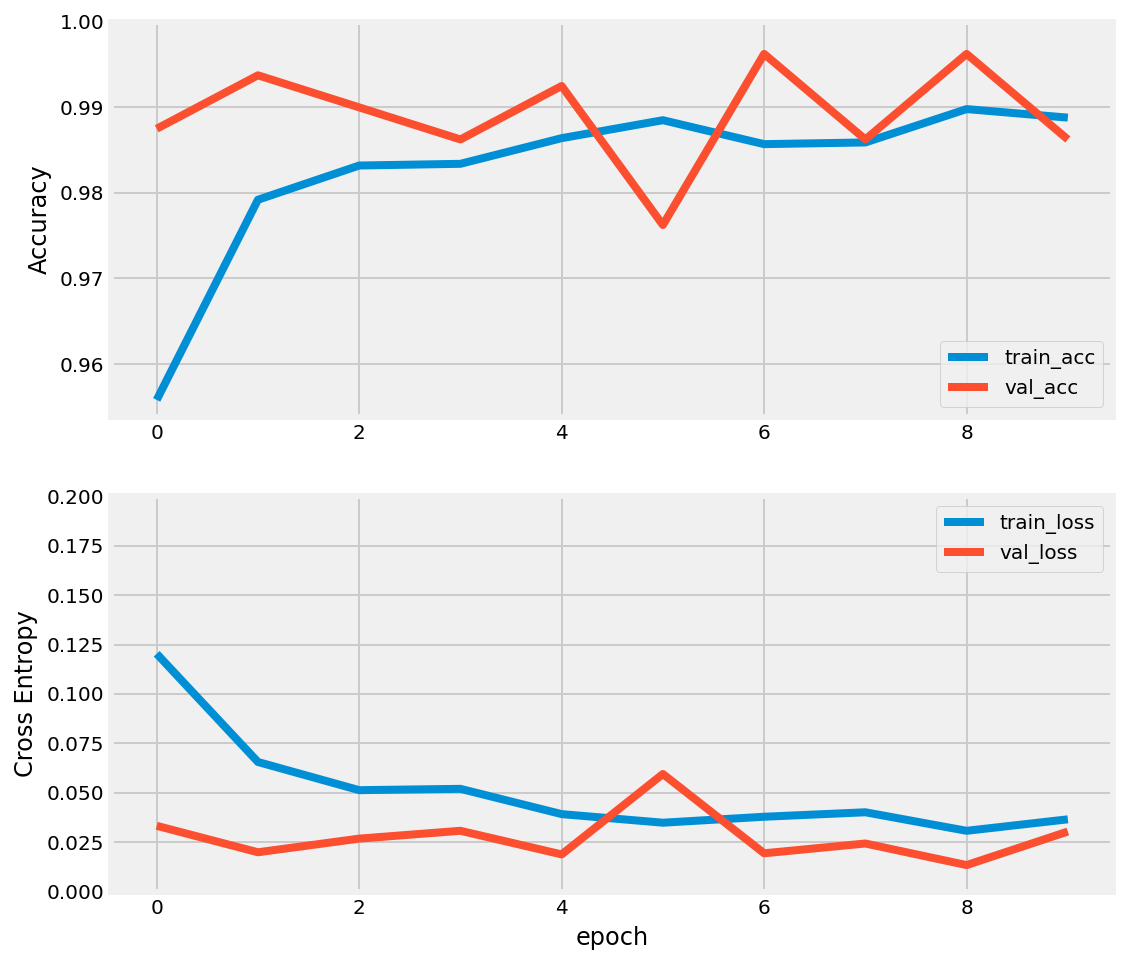

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.ylabel('Cross Entropy')
plt.ylim([0, 0.2])
plt.xlabel('epoch')
plt.show()

In [22]:
# convert to .tflite format
saved_model_dir = 'model_mnet_binary'
tf.saved_model.save(model, saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: model_mnet_binary/assets


In [23]:
# Convert the model https://www.tensorflow.org/lite/convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbp3ixmp6/assets
